In [55]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from bluemath_tk.core.operations import spatial_gradient
from bluemath_tk.datamining.pca import PCA
from bluemath_tk.datamining.kma import KMA

In [ ]:
# Predictor data

era5 = xr.open_dataset(
    "/home/tausiaj/GitLab-GeoOcean/TESLA-curso-nov23/TESLA-curso-nov23/data/ERA5_SLP_north_atlantic_daily_1degree.nc"
)
era5["msl_gradient"] = spatial_gradient(era5["msl"])

In [7]:
era5

<xarray.Dataset> Size: 968MB
Dimensions:       (time: 29158, latitude: 50, longitude: 83)
Coordinates:
  * longitude     (longitude) float32 332B -77.62 -76.62 -75.62 ... 3.375 4.0
  * latitude      (latitude) float32 200B 53.62 52.62 51.62 ... 6.625 5.625 5.0
  * time          (time) datetime64[ns] 233kB 1944-01-01 ... 2023-10-30
Data variables:
    msl           (time, latitude, longitude) float32 484MB 1.023e+05 ... 9.9...
    msl_gradient  (time, latitude, longitude) float32 484MB 0.0 0.0 ... 0.0 0.0
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-04 16:01:10 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [16]:
pca = PCA(n_components=0.90)

pcs_ds = pca.fit_transform(
    data=era5,
    vars_to_stack=["msl", "msl_gradient"],
    coords_to_stack=["latitude", "longitude"],
    pca_dim_for_rows="time",
)

2025-03-05 21:24:02,478 - PCA - WARNING - Setting self.num_workers to 1. 
Change it using self.set_num_processors_to_use method.
2025-03-05 21:24:02,479 - PCA - INFO - Explained variance ratio: 0.9
2025-03-05 21:24:02,479 - PCA - INFO - Using PCA
2025-03-05 21:24:02,494 - PCA - INFO - Adding windows in PCA dimension for rows
2025-03-05 21:24:02,494 - PCA - INFO - Generating stacked data matrix
2025-03-05 21:24:02,494 - PCA - INFO - Generating data matrix with variables to stack: ['msl', 'msl_gradient'] and coordinates to stack: ['latitude', 'longitude']



        -------------------------------------------------------------------
        | Initializing PCA reduction model with the following parameters:
        |    - n_components: 0.9
        |    - is_incremental: False
        | For more information, please refer to the documentation.
        -------------------------------------------------------------------
        


2025-03-05 21:24:03,437 - PCA - INFO - Data matrix generated successfully with shape: (29158, 8300)
2025-03-05 21:24:03,439 - PCA - INFO - Standarizing data matrix
2025-03-05 21:24:04,958 - PCA - INFO - Data preprocessed successfully
2025-03-05 21:24:05,828 - PCA - INFO - Fitting PCA model
2025-03-05 21:26:11,531 - PCA - INFO - PCA model fitted successfully


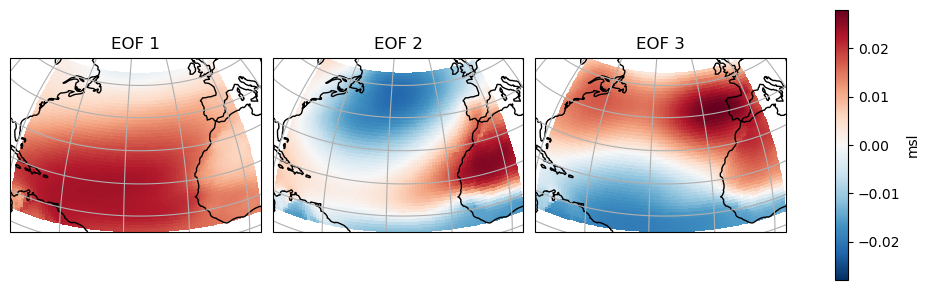

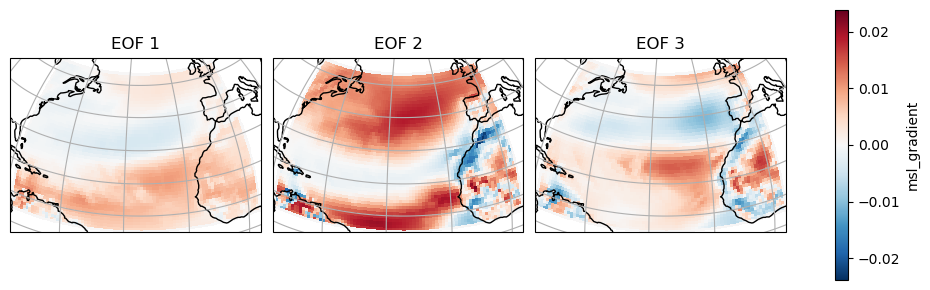

In [19]:
pca.plot_eofs(vars_to_plot=["msl", "msl_gradient"], num_eofs=3, map_center=(-35, 30))

In [30]:
kma = KMA(num_clusters=36)

pcs_centroids, _pcs_centroids_values = kma.fit_predict(data=pca.pcs_df.iloc[:, :5])

2025-03-05 21:40:36,816 - KMA - WARNING - Setting self.num_workers to 1. 
Change it using self.set_num_processors_to_use method.


(<Figure size 640x480 with 10 Axes>,
 array([[<Axes: xlabel='PC2', ylabel='PC1'>, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: xlabel='PC3', ylabel='PC2'>, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: xlabel='PC4', ylabel='PC3'>, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: xlabel='PC5', ylabel='PC4'>]],
       dtype=object))

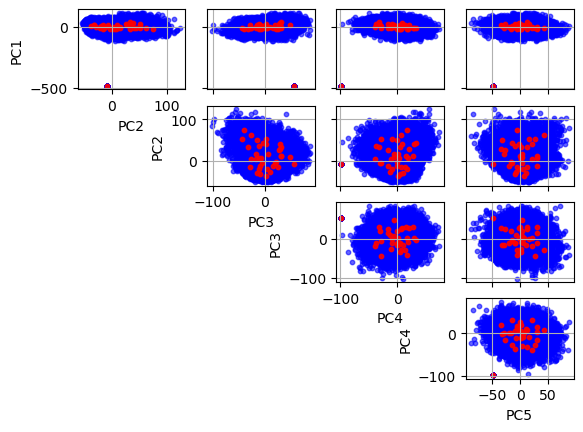

In [29]:
kma.plot_selected_centroids(plot_text=False)

In [38]:
era5["kma_bmus"] = (("time"), pcs_centroids)
era5

<xarray.Dataset> Size: 968MB
Dimensions:       (time: 29158, latitude: 50, longitude: 83)
Coordinates:
  * longitude     (longitude) float32 332B -77.62 -76.62 -75.62 ... 3.375 4.0
  * latitude      (latitude) float32 200B 53.62 52.62 51.62 ... 6.625 5.625 5.0
  * time          (time) datetime64[ns] 233kB 1944-01-01 ... 2023-10-30
Data variables:
    msl           (time, latitude, longitude) float32 484MB 1.023e+05 ... 9.9...
    msl_gradient  (time, latitude, longitude) float32 484MB 0.0 0.0 ... 0.0 0.0
    kma_bmus      (time) int32 117kB 27 10 10 10 10 10 18 ... 12 12 12 12 12 12
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-04 16:01:10 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

/tmp/ipykernel_651546/3066176050.py:10: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in p.axes.flat:


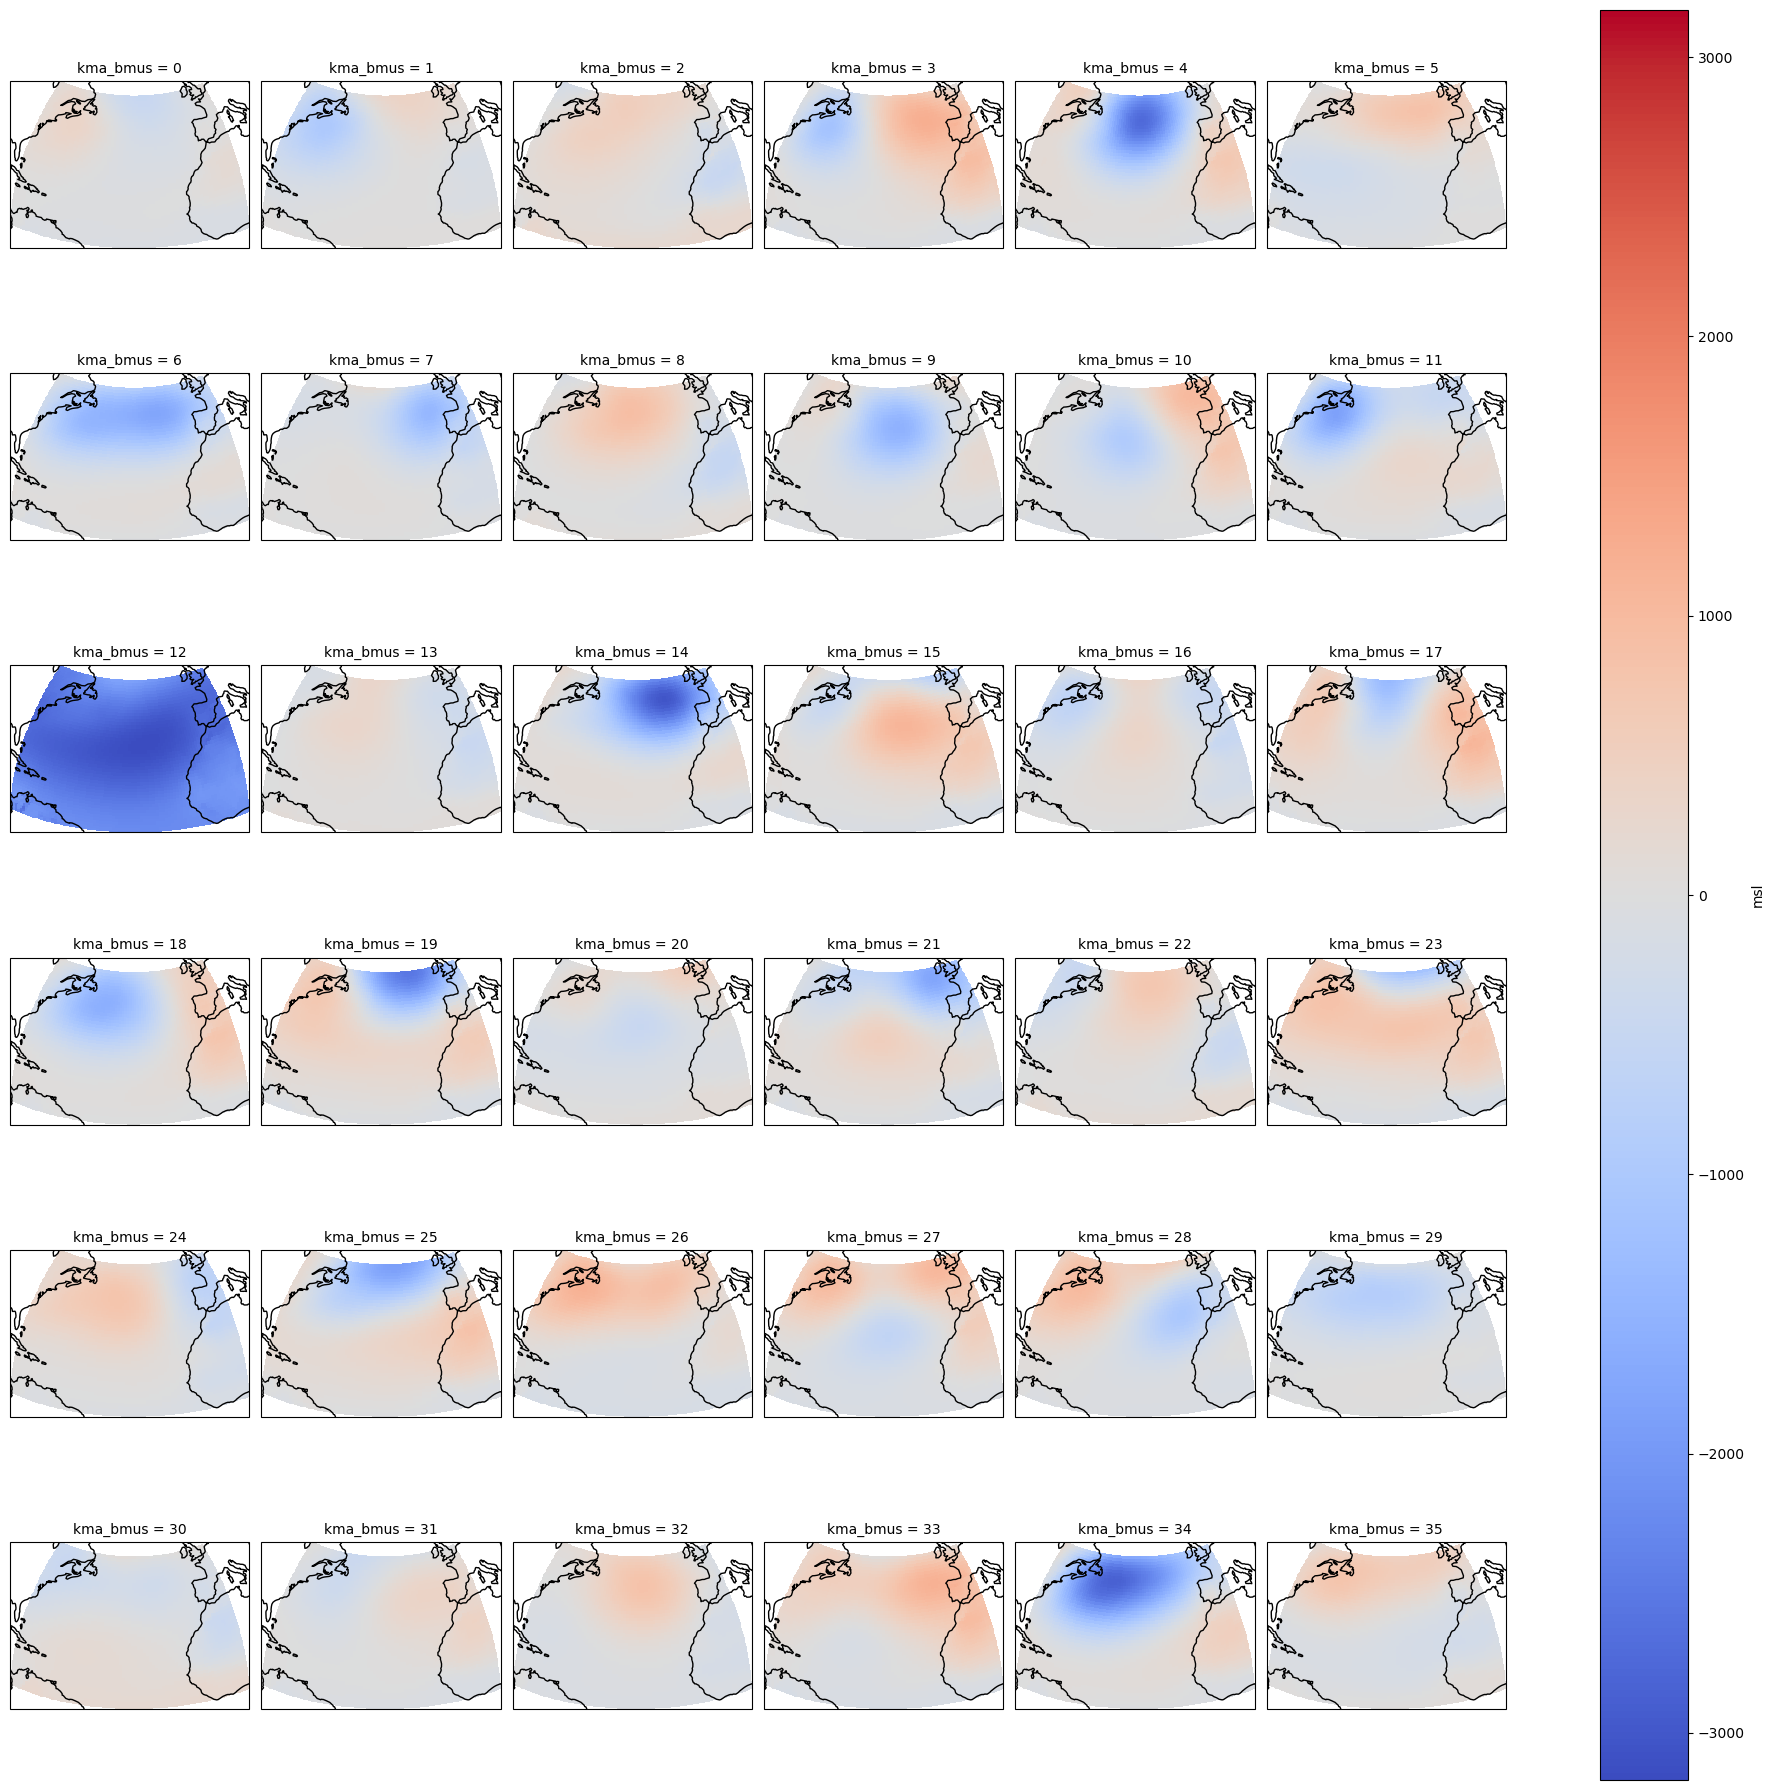

In [51]:
p = (
    era5.groupby("kma_bmus").mean()["msl"] - era5["msl"].mean("time")
).plot(
    col="kma_bmus",
    col_wrap=6,
    cmap="coolwarm",
    subplot_kws={"projection": ccrs.Orthographic(-35, 30)},
    transform=ccrs.PlateCarree(),
)
for ax in p.axes.flat:
    ax.coastlines()

In [27]:
# Predictand data

GOS_ds = xr.open_dataset(
    "/home/tausiaj/GitLab-GeoOcean/TESLA-curso-nov23/TESLA-curso-nov23/data/GOS_Galicia.nc"
).resample(time="1d").mean()

waves_ds = (
    xr.open_dataset(
        "/home/tausiaj/GitLab-GeoOcean/TESLA-curso-nov23/TESLA-curso-nov23/data/gridded_351.200_43.600.nc"
    )[["hs", "fp", "t02", "dir"]]
    .resample(time="1d")
    .mean()
)

In [41]:
GOS_ds["kma_bmus"] = (("time"), era5["kma_bmus"].sel(time=GOS_ds.time, method="nearest").values)
waves_ds["kma_bmus"] = (("time"), era5["kma_bmus"].sel(time=waves_ds.time, method="nearest").values)

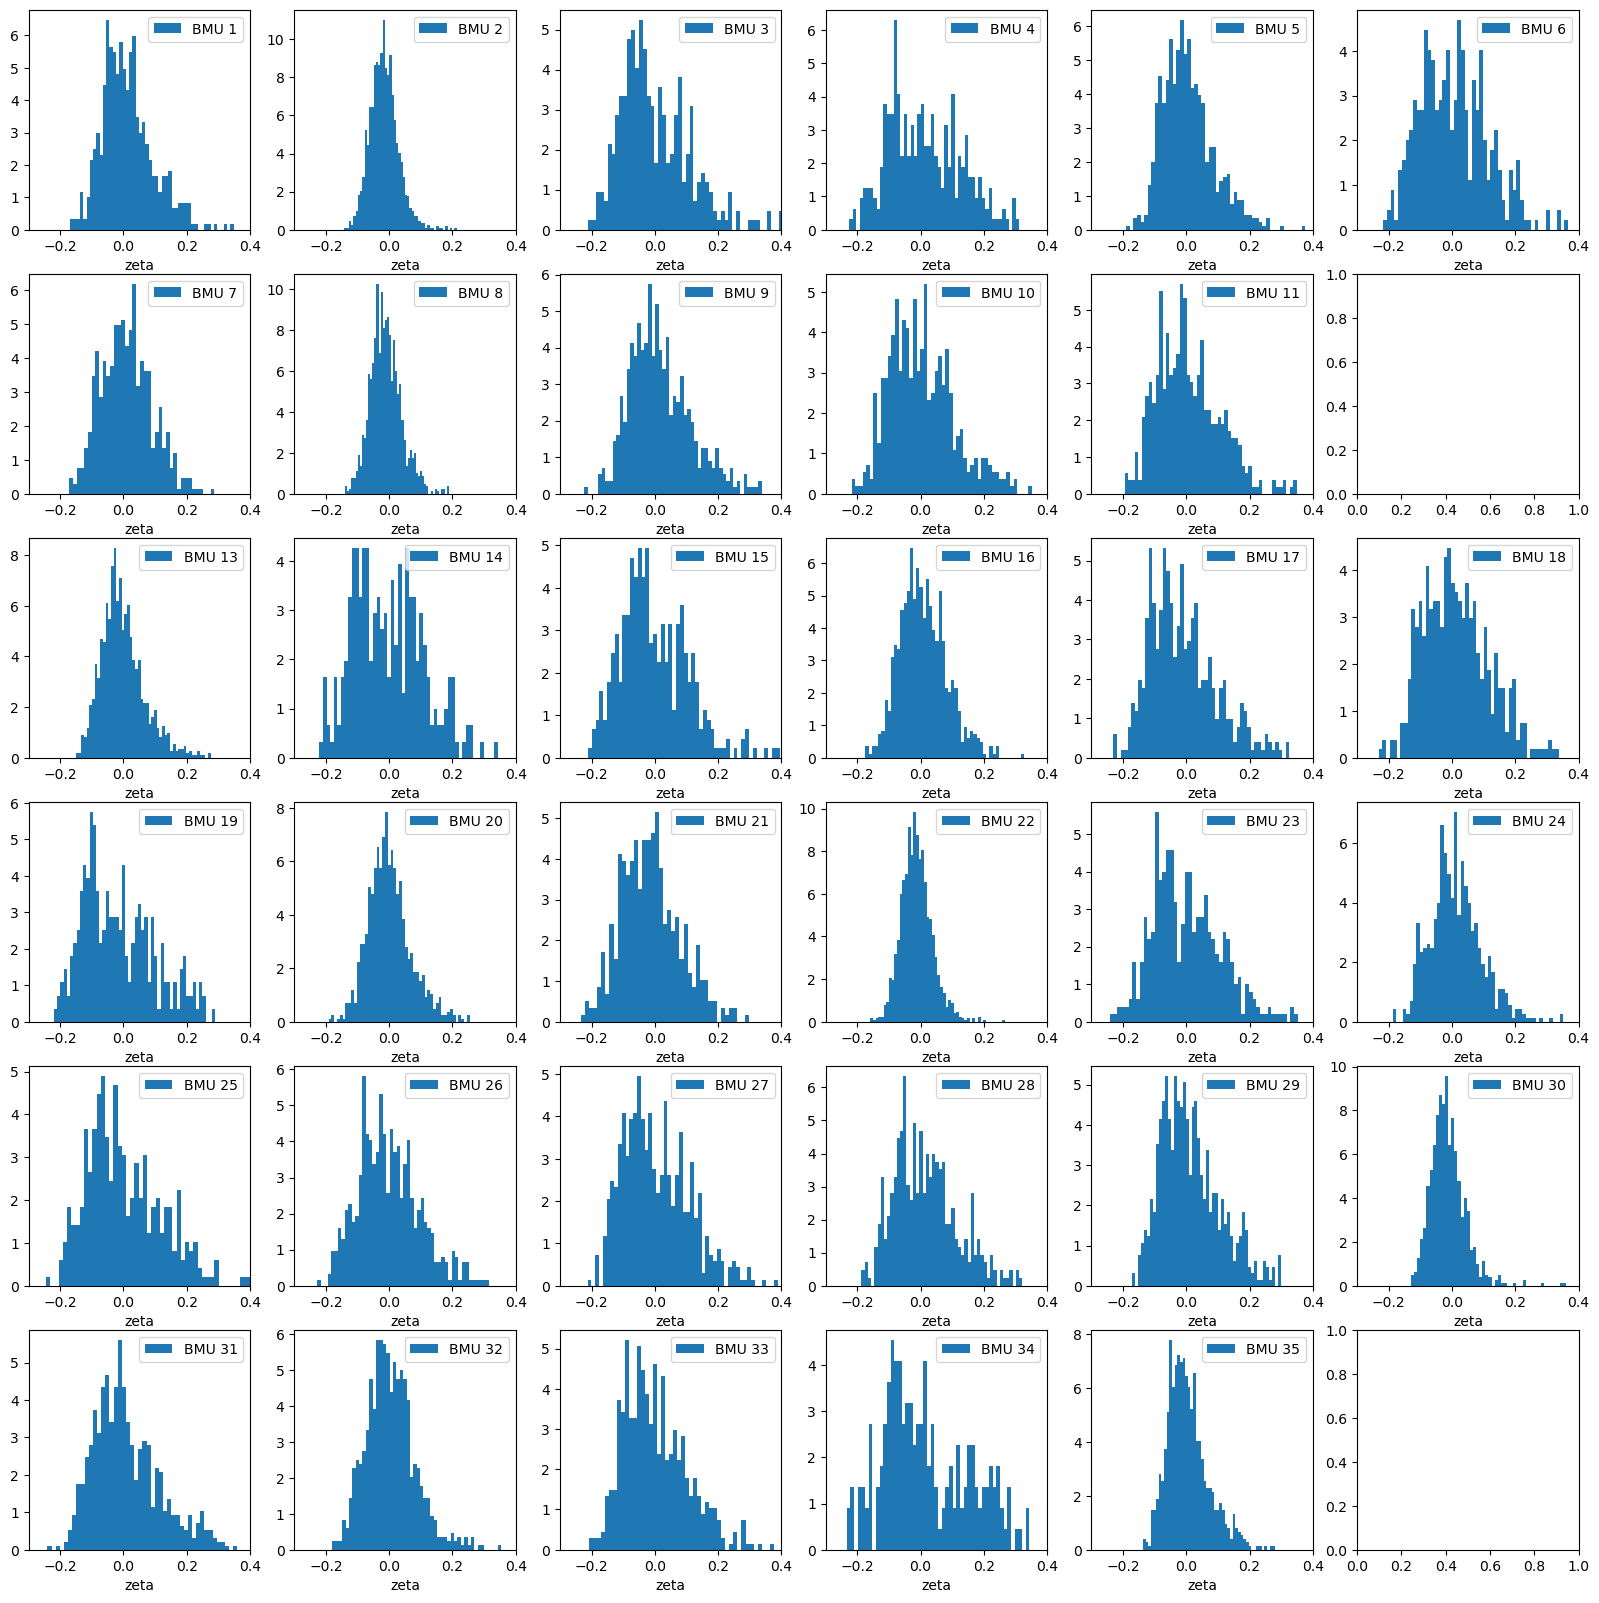

In [62]:
fig, axes = plt.subplots(6, 6, figsize=(20, 20))
for ax, kma_bmus_index in zip(axes.flatten(), range(1, 37)):
    bmus_indexes = np.where(GOS_ds["kma_bmus"].values == kma_bmus_index)[0]
    try:
        GOS_ds["zeta"].isel(time=bmus_indexes).squeeze().plot.hist(ax=ax, density=True, bins=50, label=f"BMU {kma_bmus_index}")
        ax.legend()
        ax.set_xlim(-0.3, 0.4)
    except:
        pass

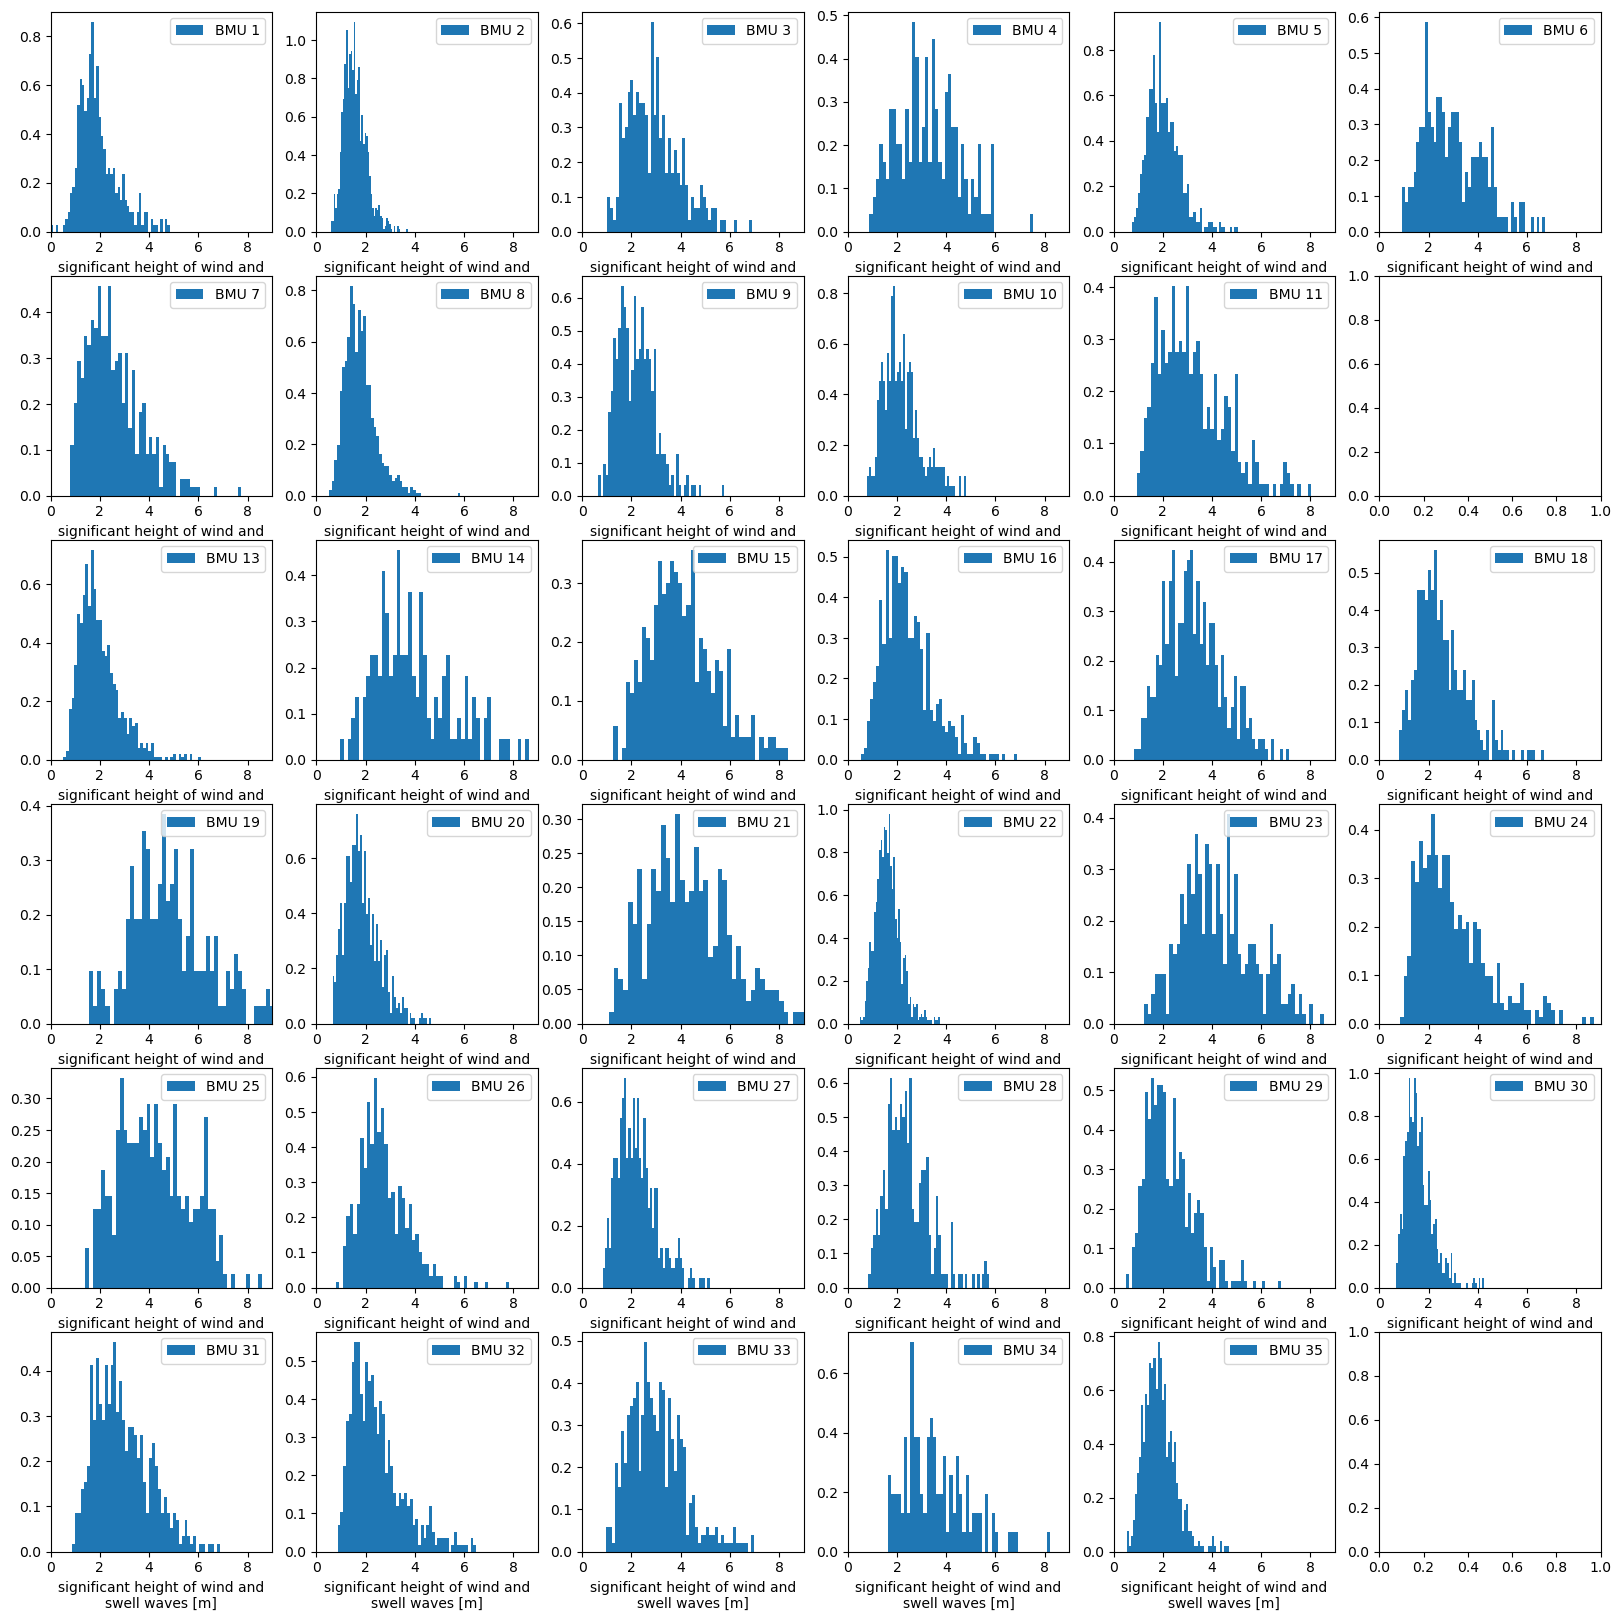

In [65]:
fig, axes = plt.subplots(6, 6, figsize=(20, 20))
for ax, kma_bmus_index in zip(axes.flatten(), range(1, 37)):
    bmus_indexes = np.where(waves_ds["kma_bmus"].values == kma_bmus_index)[0]
    try:
        waves_ds["hs"].isel(time=bmus_indexes).squeeze().plot.hist(ax=ax, density=True, bins=50, label=f"BMU {kma_bmus_index}")
        ax.legend()
        ax.set_xlim(0, 9)
        ax.set_title("")
    except:
        pass